# **BITS F464 - Semester 1 - MACHINE LEARNING**
--------------------------------------------------------------------------------

**ASSIGNMENT 1 - LINEAR MODELS FOR REGRESSION AND CLASSIFICATION**
--------------------------------------------------------------------------------
***Team number: 13***

---
***Team Members: ANIRUDH BAGALKOTKER, KARTIK PANDEY, ADWAIT KULKARNI, JOY SINHA, PIYUSH JAJRA***

---
***IDs: 2021A7PS2682H, 2021A7PS2574H, 2021A7PS2995H, 2021A8PS1606H, 2021B4A72969H***


This assignment aims to identify the differences between three sets of Machine Learning models.

# **_1. Dataset Generation_**

You are given a sample Diabetes dataset. Using this, please develop your own dataset consisting of 500 records. You can use the given code to generate your own dataset. Submit the generated dataset as a .csv file along with your python notebook.

In [ ]:
import os
from sdv.datasets.local import load_csvs
from sdv.metadata import SingleTableMetadata
from sdv.lite import SingleTablePreset
import warnings
warnings.filterwarnings( "ignore" )

# Getting the current directory using os.path and loading the csv file with the sample diabetes dataset
folderName = os.getcwd()
datasets = load_csvs(folder_name=folderName)
real_data = datasets["diabetes"]

# Generating metadata for the sample dataset
metadata = SingleTableMetadata()
metadata.detect_from_csv(filepath=folderName + "/diabetes.csv")

# Visualizing the metadata and print it
real_data.head()
metadata.visualize()
print("\n")
print(metadata.to_dict())

# Initializing a SingleTablePreset object with the metadata and fitting the synthesizer and sampling with the real_data input.
synthesizer = SingleTablePreset(metadata, name="FAST_ML")
synthesizer.fit(data=real_data)

# Generating 500 rows of synthetic data using the synthesizer and saving it as a csv and the synthesizer as a pkl
rows = 500
synthetic_data = synthesizer.sample(num_rows=rows)
synthetic_data.to_csv("synthetic_diabetes.csv", index=False)
# synthesizer.save("diabetes.pkl")
print("\nSynthetic data generated.\n")
print(synthetic_data.head())

# ***2. Preprocess and perform exploratory data analysis of the dataset obtained***

In [ ]:
from sdv.evaluation.single_table import evaluate_quality
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import random

# Preprocessing of the Synthetic Data

# Handle missing values (if any) by replacing them with the mean
synthetic_data.fillna(synthetic_data.mean(), inplace=True)

print("\nSynthetic data Preprocessed.\n")

# Exploratory Data Analysis of the Synthetic Data
print("\nEDA for Synthetic data.\n")

# Display the Outcomes and its mean
print(synthetic_data['Outcome'].value_counts())
print("\n")
print(synthetic_data.groupby('Outcome').mean())
print("\n")

# Display basic statistics
print(synthetic_data.describe())
print("\n")

# Check data types and missing values
print(synthetic_data.info())
print("\n")

# Calculate and visualize correlations between numeric columns using cluster maps and box plots using seaborn

# Calculate correlations
correlation_matrix = synthetic_data.corr()

# # Plot clustermap
# plt.figure(figsize=(10, 6))
# sns.clustermap(correlation_matrix, cmap="RdBu", center=0, cbar=True, annot=True)
# plt.title("Correlation Clustermap")
# plt.show()

# # Box plot
# plt.figure(figsize=(10, 10))
# sns.boxplot(x="Outcome", y="Glucose", data=synthetic_data)
# plt.xlabel("Outcome")
# plt.ylabel("Glucose")
# plt.title("Box Plot of Glucose by Outcome")
# plt.show()

# Evaluating the quality of the synthetic data using sdv
quality_report = evaluate_quality(real_data, synthetic_data, metadata)
quality_report.get_visualization("Column Shapes")

# Save the Synthetic Data and the Synthesizing Model after preprocessing and evaluation
synthetic_data.to_csv("synthetic_diabetes.csv", index=False)
synthesizer.save("diabetes.pkl")

# Separating the features and target
target = synthetic_data["Outcome"]
features = synthetic_data.drop(columns="Outcome", axis = 1)

# Normalization and Standardization

# Normalizing the data
# features = (features - features.min()) / (features.max() - features.min())

# Standardizing the data
features = (features - features.mean()) / features.std()

# Splitting the data into training (80%) and test (20%)
total_samples = len(features)
train_samples = int(0.8 * total_samples)

# Shuffle the indices to randomize the data
indices = np.arange(total_samples)
np.random.shuffle(indices)

# Split the indices into training and test sets
train_indices = indices[:train_samples]
test_indices = indices[train_samples:]

# Create training and test data
x_tr = features.iloc[train_indices]
y_tr = target.iloc[train_indices]
x_te = features.iloc[test_indices]
y_te = target.iloc[test_indices]

# Accuracy Score functions

def accuracy_score(y_pred, y_true):
	"""
	The accuracy_score function takes in two arrays of labels and returns the fraction
	of time that they are equal. This is known as the accuracy score, or more commonly,
	the classification rate. The function can also take an optional third parameter to specify 
	a normalization method for when there are unequal numbers of predictions between classes.

	:param y_pred: Input the predicted values of y
	:param y_true: Pass in the actual labels of the data and y_pred is used to pass in our predicted labels
	:return: The fraction of correct predictions
	"""

	num_correct = np.sum(y_true == y_pred)
	num_total = len(y_true)

	return (num_correct / num_total) * 100


def calculate_metrics(y_true, y_pred):
    # Calculate true positives, false positives, false negatives
    tp = sum(1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 1)
    fp = sum(1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 1)
    fn = sum(1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 0)

    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return f1 * 100



# ***3. Comparison of Stochastic Gradient Descent and Batch Gradient Descent using Linear Regression***

## **_Stochastic Gradient Descent_**

In [ ]:
X=synthetic_data.iloc[:,:-1].values
y=synthetic_data.iloc[:,-1].values

def scale_features(X):
    X_scaled = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return X_scaled

# Scale features
X_scaled = scale_features(X)
X = np.column_stack((np.ones(len(X_scaled)), X_scaled))

def train_test_split(X, y, test_ratio=0.2):
    num_samples = len(X)
    num_test_samples = int(test_ratio * num_samples)
    test_indices = random.sample(range(num_samples), num_test_samples)
    train_indices = [i for i in range(num_samples) if i not in test_indices]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_ratio=0.2)

def predict(X, weights):
    y_pred=X.dot(weights)
    return y_pred

def gradient(X,y,weights):
    y_pred=predict(X,weights)
    grad=2*X.T.dot(y_pred-y)
    return grad

def stochastic_gradient_descent(X,y,learning_rate=0.01, num_epochs=1000):
    num_samples, num_features=X.shape
    weights=np.random.rand(num_features)

    for epoch in range(num_epochs):
        np.random.seed(42)  # for reproducibility
        shuffled_indices = np.random.permutation(len(X))
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]
        for i in range(0,num_samples):
            grad=gradient(X_shuffled,y_shuffled, weights)
            weights-= learning_rate*grad/num_samples
    return weights

learning_rate=0.001
num_epochs=1000

weights=stochastic_gradient_descent(X_train,y_train,learning_rate, num_epochs)
print("Weights:", weights)

y_pred = predict(X_train, weights)
y_pred = np.round(y_pred).astype(int)

accuracy = calculate_metrics(y_train,y_pred)
print("\nThe Accuracy Score of Training Data: ", accuracy)

y_pred = predict(X_test, weights)
y_pred = np.round(y_pred).astype(int)

accuracy = calculate_metrics(y_test,y_pred)
print("\nThe Accuracy Score of Test Data: ", accuracy)

## **_Batch Gradient Descent_**

In [ ]:
X=synthetic_data.iloc[:,:-1].values
y=synthetic_data.iloc[:,-1].values

def scale_features(X):
    X_scaled = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return X_scaled

# Scale features
X_scaled = scale_features(X)
X = np.column_stack((np.ones(len(X_scaled)), X_scaled))

def train_test_split(X, y, test_ratio=0.2):
    num_samples = len(X)
    num_test_samples = int(test_ratio * num_samples)
    test_indices = random.sample(range(num_samples), num_test_samples)
    train_indices = [i for i in range(num_samples) if i not in test_indices]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_ratio=0.2)

def predict(X, weights):
    y_pred = X.dot(weights)
    return y_pred

def gradient(X, y, weights):
    y_pred = predict(X, weights)
    grad = 2 * X.T.dot(y_pred - y)
    return grad

def batch_gradient_descent(X, y, learning_rate=0.01, num_epochs=1000, batch_size=32):
    num_samples, num_features = X.shape
    weights = np.random.rand(num_features)

    for epoch in range(num_epochs):
        np.random.seed(42)  # for reproducibility
        shuffled_indices = np.random.permutation(len(X))
        for i in range(0, num_samples, batch_size):
            batch_indices = shuffled_indices[i:i + batch_size]
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            grad = gradient(X_batch, y_batch, weights)
            weights -= learning_rate * grad / batch_size

    return weights

learning_rate = 0.001
num_epochs = 1000

# Use batch gradient descent
weights = batch_gradient_descent(X_train, y_train, learning_rate, num_epochs, batch_size=32)
print("Weights:", weights)

y_pred = predict(X_train, weights)
y_pred = np.round(y_pred).astype(int)

accuracy = calculate_metrics(y_train,y_pred)
print("\nThe Accuracy Score of Training Data: ", accuracy)

y_pred = predict(X_test, weights)
y_pred = np.round(y_pred).astype(int)

accuracy = calculate_metrics(y_test,y_pred)
print("\nThe Accuracy Score of Test Data: ", accuracy)

## **_Insights drawn (plots, markdown explanations)_**


We will analyze the Insights between SGD and BGD by Looking into the Implementation, Performance and Accuracy.

### **Training Algorithm**

SDG updates the model weights after processing each individual training example, while BGD updates the weights after processing the entire training dataset.

SDG shuffles the training data at the epoch, while in BGD processes all the samples together in each update. Learning in SDG occurs incrementally for each sample, which leads to faster convergence, while the BGD is based on the average gradient of the entire set.

### **Coefficients Analysis**

#### **SGD**

**weights (w)** : [0.4176826, 0.10056565, 0.14534705, 0.0034014, 0.00556761, -0.00441604, 0.07195514, 0.03756527, 0.00074879]

#### **BGD**

**weights (w)** : [0.3968066, 0.0790767, 0.14720821, 0.00376867, 0.0081181, -0.01657227, 0.06447822, 0.053887,  0.01142693]

As the optimization is different, the weights are also different. BGD produces slightly smaller weights compared to SGD. BGD has more stable updates because it considers entire batch in each iteration, while SGD produces noisy updates due to consideration of single random sample at a time.

### **Accuracy**

#### **SGD**

**Training Data Accuracy: ~62%**

**Test Data Accuracy: ~58%**

#### **BGD**

**Training Data Accuracy: ~55%**

**Test Data Accuracy: ~61%**

SGD performs reasonably well in terms of the training data accuracy, however a noticeable drop is visible for test data accuracy. This suggests that the model might be slightly overfitting the training data. This could be due to the fact that the model is not able to generalize well to the unseen data. BGD on the other hand has the opposite behavior. It achieves a bit lower accuracy for training data, but performs better for test data.

BGD provides more stability as it has more stable weight updates. SGD converges faster in terms of iterations, but its path can be noisy and unstable due to the random sampling.

### **Comparison and Insights**

1.  Surprisingly, BGD performs better for test/unseen data, while SGD performs better for training data.

2.  BGD produces smaller weights and has stable weight updates. SGD converges faster but produces noisy updates.

3.  The choice between SGD and BGD depends on factors like dataset, model complexity, computational resources and required speed. But generally SGD is preferred over BGD due its speed. Experimenting with the hyperparameters like `learning_rate`, `batch_size` and `num_epochs` can help in finding optimal model.


<!-- Explain your model Implementation using mathematical formulas and algorithms -->

# **_4. Comparison of Lasso and Ridge Regression using Polynomial Regression_**

## **_Lasso Regression_**

In [ ]:
class LassoRegression:


    # defining the constructor with learning rate and no of iterations (Hyperparameters)
    def __init__(self, learning_rate, no_of_iterations, alpha):
        """
		The __init__ function is called when the class is instantiated.
		Sets up the initial values of all attributes, and it can also do any other setup that might be necessary for 
		your object to function properly.
		
		:param self: Represent the instance of the class
		:param learning_rate: Control how much the weights are adjusted each time
		:param no_of_iterations: Set the number of iterations for which we want to run the gradient descent algorithm
        :param alpha: Regularization parameter
		:return: Nothing
		"""

        self.learning_rate = learning_rate
        self.no_of_iterations = no_of_iterations
        self.alpha = alpha


    # model function to train the model with dataset
    def model(self, X, Y):
        """
		The model function is used to train the model.
		It takes in two parameters: X and Y, which are numpy arrays/matrices of shape (m,n) and (m,1) respectively.
		The function updates the weights w and bias b using gradient descent algorithm.

		:param self: Represent the instance of the class
		:param X: Store the training data
		:param Y: Calculate the error and the weights
		:return: Nothing
		"""

        # Initialize the weights and bias
        self.m, self.n = X.shape
        self.w = np.zeros(self.n)
        self.b = 0
        self.X = X
        self.Y = Y

        # implementing gradient descent for optimization
        for i in range(self.no_of_iterations):
            self.update_weights_and_bias()


    # function for updating the weights and bias using gradient descent
    def update_weights_and_bias(self):
        """
		The update_weights_and_bias function updates the weights and bias using the gradient descent formula.
		The function takes in no arguments, but uses self.w, self.b, self.alpha, self.X and self.Y to update 
		the weights and bias.

		:param self: Represent the instance of the class
		:return: The updated weights and bias
		"""
        
        Y_hat = 1 / (1 + np.exp(-(self.X.dot(self.w) + self.b)))
        dw = (1/self.m) * np.dot(self.X.T, (Y_hat - self.Y))
        db = (1/self.m) * np.sum(Y_hat - self.Y)

        # Update the weights and bias using Lasso regularization
        self.w = self.w - self.learning_rate * (dw + self.alpha * np.sign(self.w))
        self.b = self.b - self.learning_rate * db


    # predict function to predict the output using the trained model
    def predict(self, X):
        """
        The predict function takes in a matrix of data points and returns the predicted class for each point.
        The predict function calculates the probability that each data point belongs to the positive class, which is 
        then used to determine if the label should be 1 or 0. If Y_hat > 0.5, then it is classified as 1; 
        otherwise it is classified as 0.
        
        :param self: Represent the instance of the class
        :param X: Pass the input data to the model
        :return: The predicted value of the input x
        """
        
        Y_pred = 1 / (1 + np.exp(-(X.dot(self.w) + self.b)))
        Y_pred = np.where(Y_pred > 0.5, 1, 0)
        return Y_pred


    # get_coefficients function to get the coefficients of the trained model
    def get_coefficients(self):
        """
        The get_coefficients function returns the weights and bias of the perceptron.
        
        :param self: Represent the instance of the class
        :return: The weights and bias of the perceptron
        """
        return self.w, self.b


# Training the model
classifierLR = LassoRegression(learning_rate=0.01, no_of_iterations=1000, alpha=0.01)
classifierLR.model(x_tr, y_tr)

# Get and print the Lasso coefficients
lasso_coefficients = classifierLR.get_coefficients()
print("Lasso Coefficients:")
print("Coefficients (w):", lasso_coefficients[0])
print("Bias (b):", lasso_coefficients[1])

x_train_predict = classifierLR.predict(x_tr)
train_data_accuracy = accuracy_score(x_train_predict, y_tr)

print("\nThe Accuracy Score of Training Data: ", train_data_accuracy)

# # Calculate Mean Squared Error (MSE) manually
# mse = np.mean((y_te - x_train_predict) ** 2)

# # Calculate R-squared (R2) manually
# y_mean = np.mean(y_te)
# ss_total = np.sum((y_te - y_mean) ** 2)
# ss_residual = np.sum((y_te - x_train_predict) ** 2)
# r2 = 1 - (ss_residual / ss_total)

# print(f"Mean Squared Error (MSE): {mse}")
# print(f"R-squared (R2): {r2}")

# Model Evaluation for Test Data
x_test_predict = classifierLR.predict(x_te)
test_data_accuracy = accuracy_score(x_test_predict, y_te)

print("\nThe Accuracy Score of Test Data: ", test_data_accuracy)


## **_Ridge Regression_**

In [ ]:
class RidgeRegression:


    # defining the constructor with learning rate and no of iterations (Hyperparameters)
    def __init__(self, learning_rate, no_of_iterations, alpha):
        """
		The __init__ function is called when the class is instantiated.
		Sets up the initial values of all attributes, and it can also do any other setup that might be necessary for 
		your object to function properly.
		
		:param self: Represent the instance of the class
		:param learning_rate: Control how much the weights are adjusted each time
		:param no_of_iterations: Set the number of iterations for which we want to run the gradient descent algorithm
        :param alpha: Regularization parameter
		:return: Nothing
		"""
        
        self.learning_rate = learning_rate
        self.no_of_iterations = no_of_iterations
        self.alpha = alpha


    # model function to train the model with dataset
    def model(self, X, Y):
        """
		The model function is used to train the model.
		It takes in two parameters: X and Y, which are numpy arrays/matrices of shape (m,n) and (m,1) respectively.
		The function updates the weights w and bias b using gradient descent algorithm.

		:param self: Represent the instance of the class
		:param X: Store the training data
		:param Y: Calculate the error and the weights
		:return: Nothing
		"""

        self.m, self.n = X.shape
        self.w = np.zeros(self.n)
        self.b = 0
        self.X = X
        self.Y = Y

        for i in range(self.no_of_iterations):
            self.update_weights_and_bias()


    # function for updating the weights and bias using gradient descent
    def update_weights_and_bias(self):
        """
		The update_weights_and_bias function updates the weights and bias using the gradient descent formula.
		The function takes in no arguments, but uses self.w, self.b, self.alpha, self.X and self.Y to update 
		the weights and bias.

		:param self: Represent the instance of the class
		:return: The updated weights and bias
		"""

        Y_hat = 1 / (1 + np.exp(-(self.X.dot(self.w) + self.b)))
        dw = (1/self.m) * np.dot(self.X.T, (Y_hat - self.Y))
        db = (1/self.m) * np.sum(Y_hat - self.Y)

        # Update the weights and bias using Ridge regularization
        self.w = self.w - self.learning_rate * (dw + 2 * self.alpha * self.w)
        self.b = self.b - self.learning_rate * db

    # predict function to predict the output using the trained model
    def predict(self, X):
        """
        The predict function takes in a matrix of data points and returns the predicted class for each point.
        The predict function calculates the probability that each data point belongs to the positive class, which is 
        then used to determine if the label should be 1 or 0. If Y_hat > 0.5, then it is classified as 1; 
        otherwise it is classified as 0.
        
        :param self: Represent the instance of the class
        :param X: Pass the input data to the model
        :return: The predicted value of the input x
        """
        
        Y_pred = 1 / (1 + np.exp(-(X.dot(self.w) + self.b)))
        Y_pred = np.where(Y_pred > 0.5, 1, 0)
        return Y_pred


    # get_coefficients function to get the coefficients of the trained model
    def get_coefficients(self):
        """
        The get_coefficients function returns the weights and bias of the perceptron.
        
        :param self: Represent the instance of the class
        :return: The weights and bias of the perceptron
        """
        return self.w, self.b


# Training the model
classifierRR = RidgeRegression(learning_rate=0.01, no_of_iterations=1000, alpha=0.01)
classifierRR.model(x_tr, y_tr)

# Get and print the Ridge coefficients
ridge_coefficients = classifierRR.get_coefficients()
print("Ridge Coefficients:")
print("Coefficients (w):", ridge_coefficients[0])
print("Bias (b):", ridge_coefficients[1])

x_train_predict = classifierRR.predict(x_tr)
train_data_accuracy = accuracy_score(x_train_predict, y_tr)

print("\nThe Accuracy Score of Training Data: ", train_data_accuracy)

# # Calculate Mean Squared Error (MSE) manually
# mse = np.mean((y_te - x_train_predict) ** 2)

# # Calculate R-squared (R2) manually
# y_mean = np.mean(y_te)
# ss_total = np.sum((y_te - y_mean) ** 2)
# ss_residual = np.sum((y_te - x_train_predict) ** 2)
# r2 = 1 - (ss_residual / ss_total)

# print(f"Mean Squared Error (MSE): {mse}")
# print(f"R-squared (R2): {r2}")

# Model Evaluation for Test Data
x_test_predict = classifierRR.predict(x_te)
test_data_accuracy = accuracy_score(x_test_predict, y_te)

print("\nThe Accuracy Score of Test Data: ", test_data_accuracy)

## **_Insights drawn (plots, markdown explanations)_**


We will analyze the Insights between Lasso Regression and Ridge Regression by Looking into the Implementation, Performance and Accuracy.

### **Coefficients Analysis**

#### **_Lasso Regression_**

**Coefficients (w)**: [ 4.02520261e-01, 4.87138065e-01, 4.91059642e-05, 8.45477045e-05, -1.09326859e-04, 2.61785942e-01, 2.55982811e-01, 2.68001219e-02]

**Bias (b)**: -0.3044113973314351

#### **_Ridge Regression_**

**Coefficients (w)**: [ 0.4109134, 0.48237903, 0.00631716, -0.0038123, 0.0035613, 0.27685469, 0.2791599, 0.05583049]

**Bias (b)**: -0.3066060451645528


Both Lasso and Ridge Regression introduce regularization terms to control the magnitude of Coefficients. Lasso uses L1 regularization which tends to sparse coefficient vectors, while Ridge uses L2 regularization which tends to produce smaller but non-zero coefficients.

### **Model Performance Analysis**

#### **_Lasso Regression_**

**Training Data Accuracy: ~70.5%**

**Test Data Accuracy: ~70%**

#### **_Ridge Regression_**

**Training Data Accuracy: ~69.5%**

**Test Data Accuracy: ~71%**

### **Comparison and Insights**

1.  Both models performed similarly on the test data, with test accuracies of around 70%. Ridge Regression performs slightly better compared to Lasso Regression.

2.  Lasso Regression tend to produce a more sparse coefficient vector (some very near to zero), indicating feature selection. Ridge produces smaller but non-zero coefficients. Both have nearly same Bias.

3.  The choice between Lasso and Ridge Regression depends on the specific requirements of the problem. If the solution requires to retain all the features with smaller coefficients then Ridge is recommended. If the solution requires to perform feature selection then Lasso is recommended.


# **_5. Comparison of Logistic Regression and Least Squares Classification_**

## **_Logistic Regression_**

In [ ]:
class Logistic_Regression():
	

	# defining the constructor with learning rate and no of iterations (Hyperparameters)
	def __init__(self, learning_rate, no_of_iterations):
		"""
		The __init__ function is called when the class is instantiated.
		Sets up the initial values of all attributes, and it can also do any other setup that might be necessary for 
		your object to function properly.
		
		:param self: Represent the instance of the class
		:param learning_rate: Control how much the weights are adjusted each time
		:param no_of_iterations: Set the number of iterations for which we want to run the gradient descent algorithm
		:return: Nothing
		"""
        
		self.learning_rate = learning_rate
		self.no_of_iterations = no_of_iterations



    # model function to train the model with dataset
	def model(self, X, Y):
		"""
		The model function is used to train the model.
		It takes in two parameters: X and Y, which are numpy arrays/matrices of shape (m,n) and (m,1) respectively.
		The function updates the weights w and bias b using gradient descent algorithm.

		:param self: Represent the instance of the class
		:param X: Store the training data
		:param Y: Calculate the error and the weights
		:return: Nothing
		"""
		
		# number of data points(rows) = m and no of features(columns) = n
		self.m, self.n = X.shape

		# initializing the weights and bias to zero
		self.w = np.zeros(self.n)
		self.b = 0
		self.X = X
		self.Y = Y

		# implementing gradient descent for optimization
		for i in range(self.no_of_iterations):
			self.update_weights_and_bias()


	# function for updating the weights and bias using gradient descent
	def update_weights_and_bias(self):
		"""
		The update_weights_and_bias function updates the weights and bias using the gradient descent formula.
		The function takes in no arguments, but uses self.w, self.b, self.X and self.Y to update 
		the weights and bias.

		:param self: Represent the instance of the class
		:return: The updated weights and bias
		"""
		
		# weights are updated using the formula w := w - learning_rate * dw
		# bias is updated using the formula b := b - learning_rate * db

        # Y_hat formula (sigmoid function) = w.X + b
		Y_hat = 1 / (1 + np.exp(-(self.X.dot(self.w) + self.b)))
        
        # derivatives
		dw = (1/self.m)*np.dot(self.X.T, (Y_hat - self.Y))
		db = (1/self.m)*np.sum(Y_hat - self.Y)

		# updating the weights and bias using the gradient descent formula
		self.w = self.w - self.learning_rate * dw
		self.b = self.b - self.learning_rate * db



	# predict function to predict the output using Sigmoid Equation and Decision Boundary
	def predict(self, X):
		"""
		The predict function takes in a matrix of features and returns the predicted labels for each row.
		The predict function uses the sigmoid function to calculate Y_hat, which is then used to determine if 
		the label should be 1 or 0. If Y_hat > 0.5, then it is classified as 1; otherwise it is classified as 0.

		:param self: Represent the instance of the class
		:param X: Pass the input data to the model
		:return: The predicted values of y (vector) for the given x
		"""

		# predicting the output by checking Y_hat > 0.5 for 1 and Y_hat <= 0.5 for 0
		Y_pred = 1 / (1 + np.exp(-(X.dot(self.w) + self.b)))
		Y_pred = np.where(Y_pred > 0.5, 1, 0)
		return Y_pred

# Training the model
classifierLR = Logistic_Regression(learning_rate=0.01, no_of_iterations=1000)
classifierLR.model(x_tr, y_tr)

# Model Evaluation

# Model Evaluation for Training Data
x_train_predict = classifierLR.predict(x_tr)
train_data_accuracy = accuracy_score(x_train_predict, y_tr)

print("\nThe Accuracy Score of Training Data: ", train_data_accuracy)

# Model Evaluation for Test Data
x_test_predict = classifierLR.predict(x_te)
test_data_accuracy = accuracy_score(x_test_predict, y_te)

print("\nThe Accuracy Score of Test Data: ", test_data_accuracy)


## **_Least Squares Classification_**

In [ ]:
class LMSClassifier:


    # defining the constructor with learning rate and no of iterations (Hyperparameters)
    def __init__(self, learning_rate, no_of_iterations):
        """
		The __init__ function is called when the class is instantiated.
		Sets up the initial values of all attributes, and it can also do any other setup that might be necessary for 
		your object to function properly.
		
		:param self: Represent the instance of the class
		:param learning_rate: Control how much the weights are adjusted each time
		:param no_of_iterations: Set the number of iterations for which we want to run the gradient descent algorithm
		:return: Nothing
		"""

        self.learning_rate = learning_rate
        self.no_of_iterations = no_of_iterations


    # model function to train the model with dataset
    def model(self, X, Y):
        """
		The model function is used to train the model.
		It takes in two parameters: X and Y, which are numpy arrays/matrices of shape (m,n) and (m,1) respectively.
		The function updates the weights w and bias b using gradient descent algorithm.

		:param self: Represent the instance of the class
		:param X: Store the training data
		:param Y: Calculate the error and the weights
		:return: Nothing
		"""
        
        no_samples, no_features = X.shape
        X = X.to_numpy()
        Y = Y.to_numpy()
        
        # Initializing array of ones
        X1 = np.ones(no_samples)
        X1 = X1.reshape(1,no_samples)
        
        # Transform and concatenate columns of the input array X into the new array X1
        for j in range(no_features):
            x_i = X[:, j].reshape(-1, 1)
            x_i = x_i.T
            X1 = np.concatenate((X1, x_i), axis=0)
        
        Y = Y.reshape(-1, 1)
        X1 = X1.T
        
        # Compute the coefficients (beta) for linear regression using the pseudo-inverse method
        self.beta = np.linalg.pinv(X1.T @ X1) @ (X1.T @ Y)


    # predict function to predict the output using the coefficients (beta)
    def predict(self, X_test):
        """
        The predict function takes in a matrix of test data and returns the predicted values for each sample.
        The function first adds a column of ones to the test data, then multiplies it by beta to get Y_hat.
        It then reshapes Y_hat into an array with one row and no_samples columns, which is used to calculate mean. 
        Then it loops through all elements in Y_hat and sets them equal to 0 if they are less than mean or 1 otherwise.
        
        :param self: Represent the instance of the class
        :param X_test: Pass the test data to the predict function
        :return: A vector of predictions Y_pred given X
        """
        
        no_samples, no_features = X_test.shape
        X = np.concatenate((np.ones((no_samples, 1)), X_test), axis=1)
        Y_hat = X @ self.beta
        
        # Calculate mean of Y_hat
        Y_hat = Y_hat.reshape(no_samples, )
        mean = np.mean(Y_hat)
        Y_hat = Y_hat.reshape(1, no_samples)
        
		# predicting the output by checking Y_hat > mean for 1 and Y_hat <= mean for 0
        for j in range(no_samples):
            if Y_hat[0, j] > mean:
                Y_hat[0, j] = 1
            else:
                Y_hat[0, j] = 0
        Y_pred = Y_hat.reshape(no_samples, )
        return Y_pred

# Training the model
classifierLMS = LMSClassifier(learning_rate=0.01, no_of_iterations=1000)
classifierLMS.model(x_tr, y_tr)
classifierLMS.beta

# Model Evaluation for Training Data
x_train_predict = classifierLMS.predict(x_tr)
train_data_accuracy = accuracy_score(x_train_predict, y_tr)

print("\nThe Accuracy Score of Training Data: ", train_data_accuracy)

# Model Evaluation for Test Data
x_test_predict = classifierLMS.predict(x_te)
test_data_accuracy = accuracy_score(x_test_predict, y_te)

print("\nThe Accuracy Score of Training Data: ", test_data_accuracy)


## **_Insights drawn (plots, markdown explanations)_**

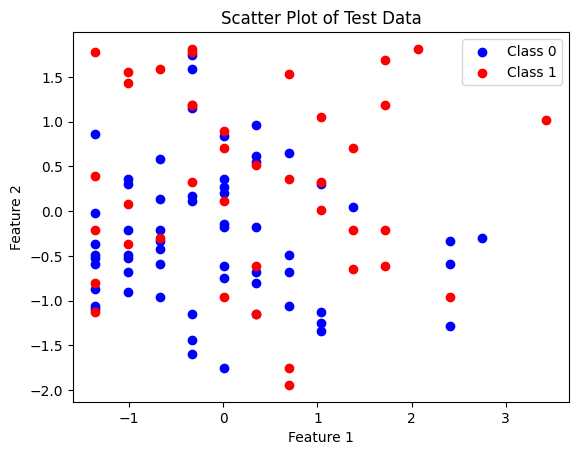

In [25]:
# Graph plotted to visualize the comparison of the models
x_te = x_te.to_numpy()
y_te = y_te.to_numpy()

class_0 = x_te[y_te == 0]
class_1 = x_te[y_te == 1]

plt.scatter(class_0[:, 0], class_0[:, 1], label="Class 0", marker='o', c='blue')
plt.scatter(class_1[:, 0], class_1[:, 1], label="Class 1", marker='o', c='red')

plt.title("Scatter Plot of Test Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

<!-- Explain your model Implementation using mathematical formulas and algorithms -->

We will analyze the Insights between Logistic Regression and Least Mean Square Classification by Looking into the Implementation, Performance and Plot the Decision Boundary for the Model

### **Logistic Regression**

#### **Implementation**

Logistic Regression is implemented as a class with methods for training and prediction. The key components includes:

1.  Constructor (`__init__`) to set the learning rate and no of iterations.
2.  `model` method to train the model using gradient descent.
3.  `update_weights_and_bias` method for updating the weights and bias.
4.  `predict` method to make predictions.

#### **Model Training**

Logistic Regression is trained using the sigmoid function to calculate the predicted values. It uses gradient descent to update weights and bias iteratively.

#### **Model Evaluation**

After Training, the model is evaluated using the accuracy score to measure the performance of the model. it is evaluated on both training and test data.

**Training Data Accuracy: ~70%**

**Test Data Accuracy: ~74%**


### **Least Mean Square Classification**

#### **Implementation**

Least Mean Square Classification is implemented as a class with methods for training and prediction. The key components include:

1.  Constructor (`__init__`) to set the learning rate and no of iterations.
2.  `mode1` method to train the model using the pseudo-inverse method
3.  `predict` method for making predictions.

#### **Model Training**

LMS Classification computes the coefficients (beta) for linear regression using the pseudo-inverse method.

#### **Evaluation**

After training, the model is evaluated on both the training and test data using accuracy scores.

**Training Data Accuracy: ~66.5%**

**Test Data Accuracy: ~67%**

### **Comparison and Insights**

1.  Logistic Regression generally outperforms LMS Classification in terms of accuracy.

2.  Logistic Regression is better suited for binary classification problems, especially when the relationship between features and targets is not linear as it is based on modelling the probability of target variable belonging to certain class. LMS Classification is based on Linear Regression hence does'nt perform well on binary classification problems.

3.  The choice of hyperparameters can significantly impact the performance of both methods. by fine-tuning them we can achieve better results. 

# **_5. References_**

1.   SDV: https://docs.sdv.dev/sdv/
2.   Preprocessing: https://towardsdatascience.com/data-preprocessing-and-eda-for-data-science-50ba6ea65c0a
3.   Preprocessing for Missing Data using Pandas: https://pandas.pydata.org/docs/user_guide/missing_data.html
4.   EDA using Seaborn: https://www.analyticsvidhya.com/blog/2021/08/how-to-perform-exploratory-data-analysis-a-guide-for-beginners/
5.   Plotting Graphs using Seaborn: https://seaborn.pydata.org/


